In [ ]:
# default_exp custom_pytorch_training

# Custom Pytorch Training

> Extending `pytorch` api for custom training functionality

In [ ]:
#export

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

from nbdev.export import *

### Synthetic Data Generation

In [ ]:
class NumpyDataset(data.Dataset):
    def __init__(self, array, transform=None):
        super().__init__()
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, index):
        x = self.array[index]
        if self.transform:
            x = self.transform(x)
        return x

In [ ]:
#export
def generate_1d_data(n, d):
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(n)
    b = 0.8 + 0.05 * rand.randn(n)
    mask = rand.rand(n) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, d)).astype('float32')

def generate_2d_data(n, dist):
    import itertools
    d1, d2 = dist.shape
    pairs = list(itertools.product(range(d1), range(d2)))
    idxs = np.random.choice(len(pairs), size=n, replace=True, p=dist.reshape(-1))
    samples = [pairs[i] for i in idxs]

    return np.array(samples).astype('float32')

In [ ]:
def load_data(n_train, n_test, d, loader_args, train_only=False):
    train_data, test_data = generate_1d_data(n_train, d), generate_1d_data(n_test, d)
    train_dset, test_dset = NumpyDataset(train_data), NumpyDataset(test_data)
    train_loader, test_loader = data.DataLoader(train_dset, **loader_args), data.DataLoader(test_dset, **loader_args)

    if not n_test:
        return train_loader
    return train_loader, test_loader

### Training Loops

In [ ]:
#export
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        loss = model.nll(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for x in data_loader:
            loss = model.nll(x)
            total_loss += loss * x.shape[0]
        avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss.item()


def train_epochs(model, train_loader, test_loader, train_args):
    epochs, lr = train_args['epochs'], train_args['lr']
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, test_losses = [], []
    for epoch in range(epochs):
        model.train()

        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        train_losses.append(train_loss)

        if test_loader is not None:
            test_loss = eval_loss(model, test_loader)
            test_losses.append(test_loss)

        if epoch in [0, 2, 10, 50, 99]:
            plot_hist(train_loader.dataset.array, bins=d,
                      title=f'Epoch {epoch}', density=model.get_density())
    if test_loader is not None:
      print('Test Loss', test_loss)

    plot_train_curves(epochs, train_losses, test_losses, title='Training Curve')

### Sample Pipeline

In [ ]:
def plot_hist(data, bins=10, xlabel='x', ylabel='Probability', title='', density=None):
    bins = np.concatenate((np.arange(bins) - 0.5, [bins - 1 + 0.5]))

    plt.figure()
    plt.hist(data, bins=bins, density=True)

    if density:
        plt.plot(density[0], density[1], label='distribution')
        plt.legend()

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

def plot_train_curves(epochs, train_losses, test_losses, title=''):
    x = np.linspace(0, epochs, len(train_losses))
    plt.figure()
    plt.plot(x, train_losses, label='train_loss')
    if test_losses:
        plt.plot(x, test_losses, label='test_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()


def visualize_batch(batch_tensor, nrow=8, title='', figsize=None):
    grid_img = make_grid(batch_tensor, nrow=nrow)
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.axis('off')
    plt.show()


In [ ]:
# export
class Histogram(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d), requires_grad=True)

    # Compute loss as negative log-likelihood
    def nll(self, x):
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1) # batch_size x d
        return F.cross_entropy(logits, x.long())

    def get_density(self):
        x = np.linspace(-0.5, self.d - 0.5, 1000)
        with torch.no_grad():
            y = F.softmax(self.logits, dim=0).unsqueeze(1).repeat(1, 1000 // self.d).view(-1).numpy()
        return x, y

class MixtureOfLogistics(nn.Module):
    def __init__(self, d, n_mix=4):
        super().__init__()
        self.d = d
        self.n_mix = n_mix

        self.logits = nn.Parameter(torch.zeros(n_mix), requires_grad=True)
        self.means = nn.Parameter(torch.arange(n_mix).float() / (n_mix - 1) * d, requires_grad=True)
        self.log_scales = nn.Parameter(torch.randn(n_mix), requires_grad=True)

    def nll(self, x):
        x = x.unsqueeze(1).repeat(1, self.n_mix) # b x n_mix
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0) # 1 x n_mix
        inv_scales = torch.exp(-log_scales)

        plus_in = inv_scales * (x + 0.5 - means)
        min_in = inv_scales * (x - 0.5 - means)

        cdf_plus = torch.sigmoid(plus_in) # CDF of logistics at x + 0.5
        cdf_min = torch.sigmoid(min_in) # CDF of logistics at x - 0.5

        cdf_delta = cdf_plus - cdf_min # probability of x in bin [x - 0.5, x + 0.5]
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=1e-12))
        log_cdf_plus = torch.sigmoid(inv_scales * (0.5 - means))
        log_cdf_min = torch.sigmoid(inv_scales * (d - 1.5 - means))

        x_log_probs = torch.where(x < 0.001, log_cdf_plus,
                                  torch.where(x > d - 1 - 1e-3,
                                              log_cdf_min, log_cdf_delta))
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return -torch.mean(torch.logsumexp(log_probs, dim=1))

    def get_density(self):
        x = np.linspace(-0.5, self.d - 1 + 0.5, 1000)

        with torch.no_grad():
            x_pt = torch.FloatTensor(x).unsqueeze(1)
            means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
            pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)

            # Calculate pdf of logistic distributions and weight them
            # according to learned mixture probabilities
            x_in = (x_pt - means) * torch.exp(-log_scales)
            log_pdf = x_in - log_scales - 2 * F.softplus(x_in)
            log_pdf = log_pdf + pi_log_probs
            log_pdf = torch.logsumexp(log_pdf, dim=1)
            pdf = log_pdf.exp()

        return x, pdf.numpy()

In [ ]:
SEED = 1
np.random.seed(SEED)
torch.manual_seed(SEED)

n_train, n_test, d = 1000, 500, 100
loader_args = dict(batch_size=128, shuffle=True)
train_loader, test_loader = load_data(n_train, n_test, d, loader_args)

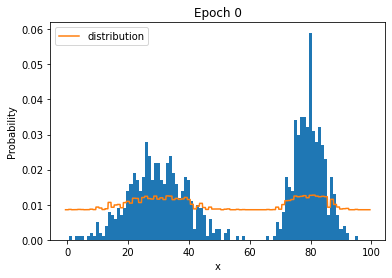

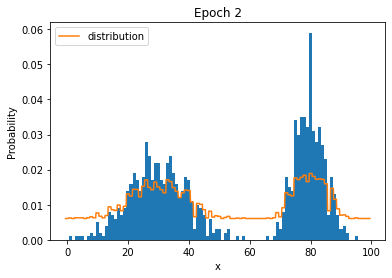

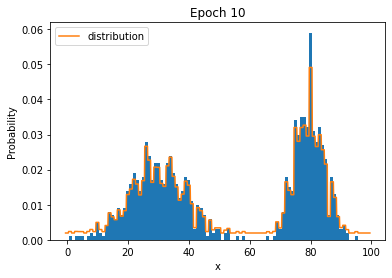

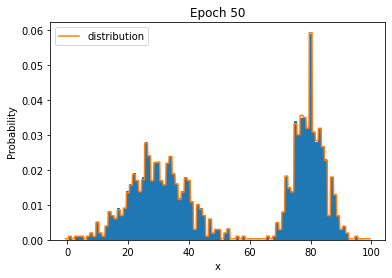

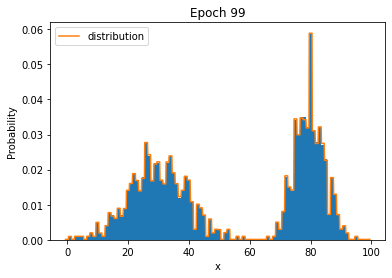

Test Loss 4.061525344848633


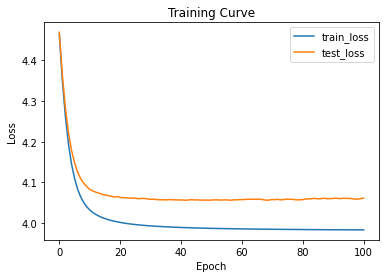

In [ ]:
hist = Histogram(d)
train_epochs(hist, train_loader, test_loader, dict(epochs=100, lr=2.5e-2))

## References